# Notebook 03: Absolute vs. Relative Measures

## How does the picture change when we compare inequality ratios vs. absolute levels?

A country can have low inequality but low absolute living standards, or high
inequality but high living standards even at the bottom. Comparing PPP-adjusted
income levels at specific percentiles reveals a more nuanced picture than
inequality ratios alone.

### Key concepts

- **Relative measures** (Gini, top shares, P90/P10): How income is distributed
  relative to the whole. A country can grow richer while staying equally unequal.
- **Absolute measures**: PPP-adjusted income at specific percentiles. How much
  purchasing power does someone at the 10th percentile actually have?
- **The social wage**: Europeans pay higher taxes but receive public services
  (healthcare, education, childcare) that don't appear in disposable income.

### PPP limitations (Deaton & Heston, 2010)

PPP adjustments are imperfect. Quality differences across countries are hard to
capture, government services are difficult to price, and the consumption baskets
of rich and poor differ substantially. These comparisons should be interpreted
with caution.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from data.config import FOCUS_COUNTRIES, COUNTRY_NAMES
from data.plotting import (set_style, country_color, country_name,
                           save_figure, annotate_countries)
from data import wid, swiid

set_style()

***
## 1. Income at Different Percentiles: US vs. Europe

Instead of asking *how unequal* a country is, we ask: how much income does
someone at the 10th, 50th, and 90th percentile actually have?

The US looks very different depending on where in the distribution you look.

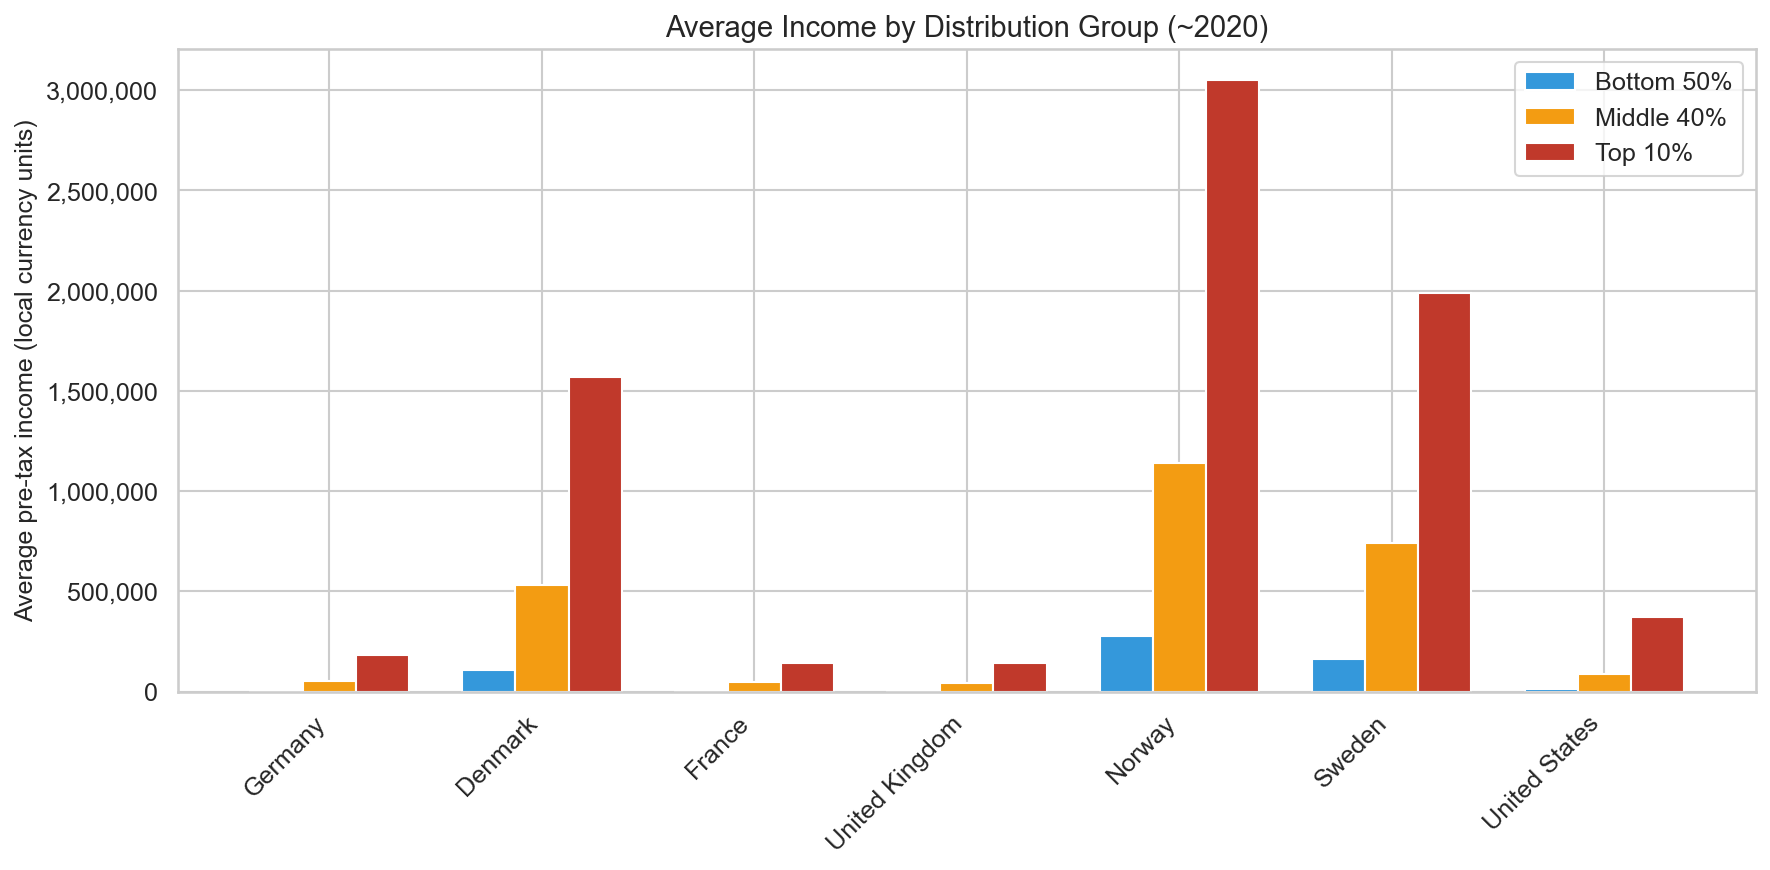


Note: WID expresses values in EUR PPP for European countries and USD for the US.


In [2]:
# Get average income at key percentile groups from WID
pct_groups = ['p0p50', 'p50p90', 'p90p100']
abs_countries = ['US', 'FR', 'DE', 'SE', 'GB', 'DK', 'NO']
target_year = 2020

avg_income = wid.get_average_income(
    abs_countries, income_concept='pretax',
    percentiles=pct_groups,
    start_year=target_year - 2, end_year=target_year + 2,
)

if not avg_income.empty:
    avg_income['year_diff'] = abs(avg_income['year'] - target_year)
    latest = (avg_income.sort_values('year_diff')
              .groupby(['country', 'percentile']).first().reset_index())
    pivot = latest.pivot(index='country', columns='percentile', values='value')

    fig, ax = plt.subplots(figsize=(12, 6))
    pct_labels = {'p0p50': 'Bottom 50%', 'p50p90': 'Middle 40%', 'p90p100': 'Top 10%'}
    pct_colors = {'p0p50': '#3498db', 'p50p90': '#f39c12', 'p90p100': '#c0392b'}
    x = np.arange(len(pivot))
    width = 0.25
    for i, pct in enumerate(pct_groups):
        if pct in pivot.columns:
            ax.bar(x + i * width, pivot[pct].values, width,
                   label=pct_labels.get(pct, pct), color=pct_colors.get(pct, '#666'))
    ax.set_xticks(x + width)
    ax.set_xticklabels([country_name(c) for c in pivot.index], rotation=45, ha='right')
    ax.set_ylabel('Average pre-tax income (local currency units)')
    ax.set_title(f'Average Income by Distribution Group (~{target_year})', fontsize=14)
    ax.legend()
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    save_figure(fig, '03_income_by_percentile')
    plt.show()
    print('\nNote: WID expresses values in EUR PPP for European countries and USD for the US.')
else:
    print('WID average income data not available.')

***
## 2. The "Scissors Chart": US/Europe Income Ratio by Decile

How does the US compare to France at each point in the distribution?
The ratio of US to French income rises sharply as you move up the distribution,
revealing that the US advantage is concentrated at the top.

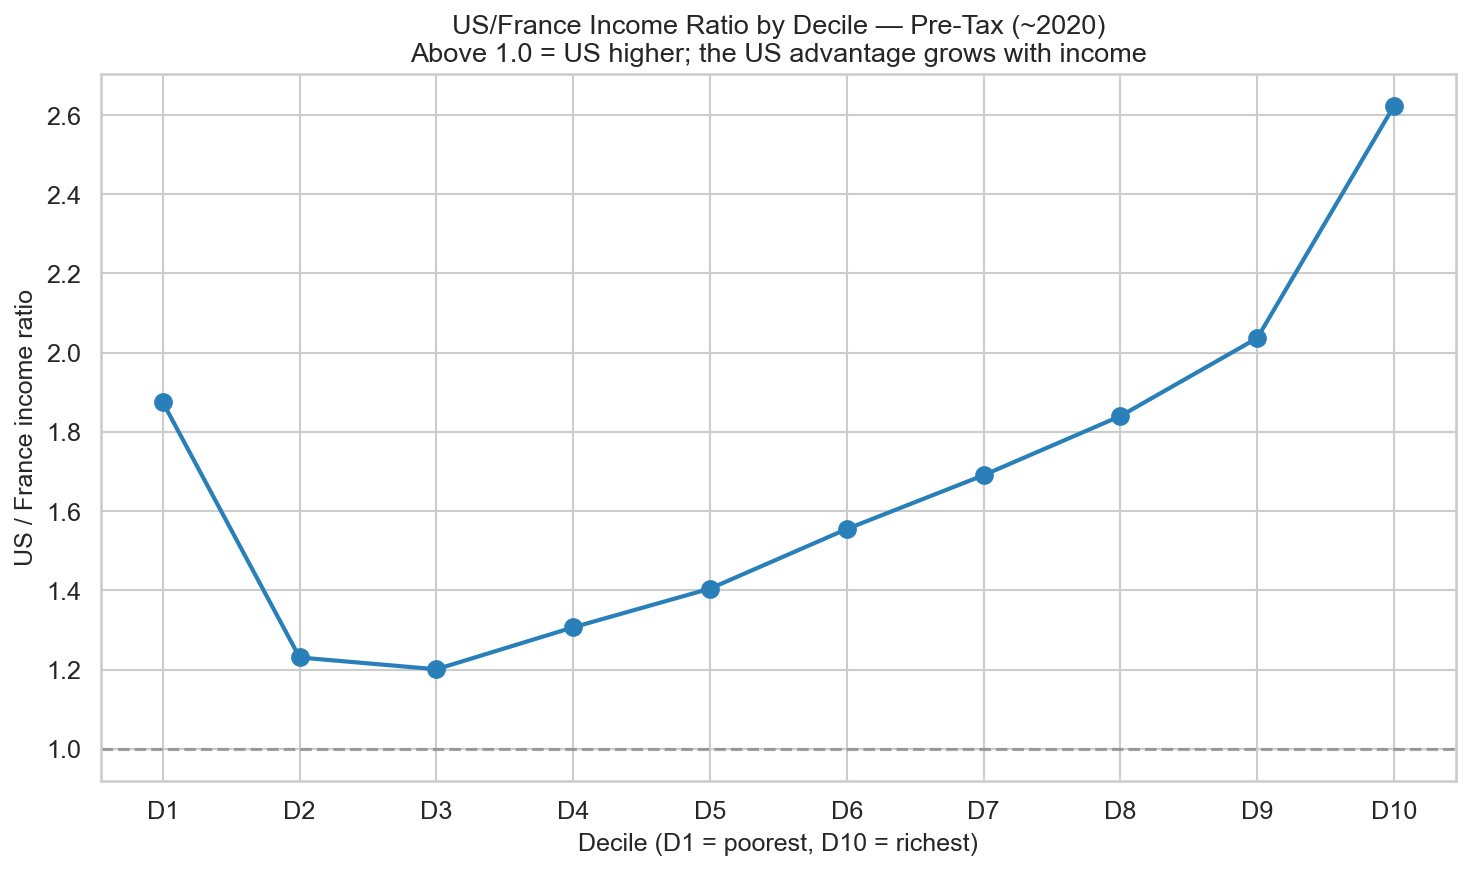

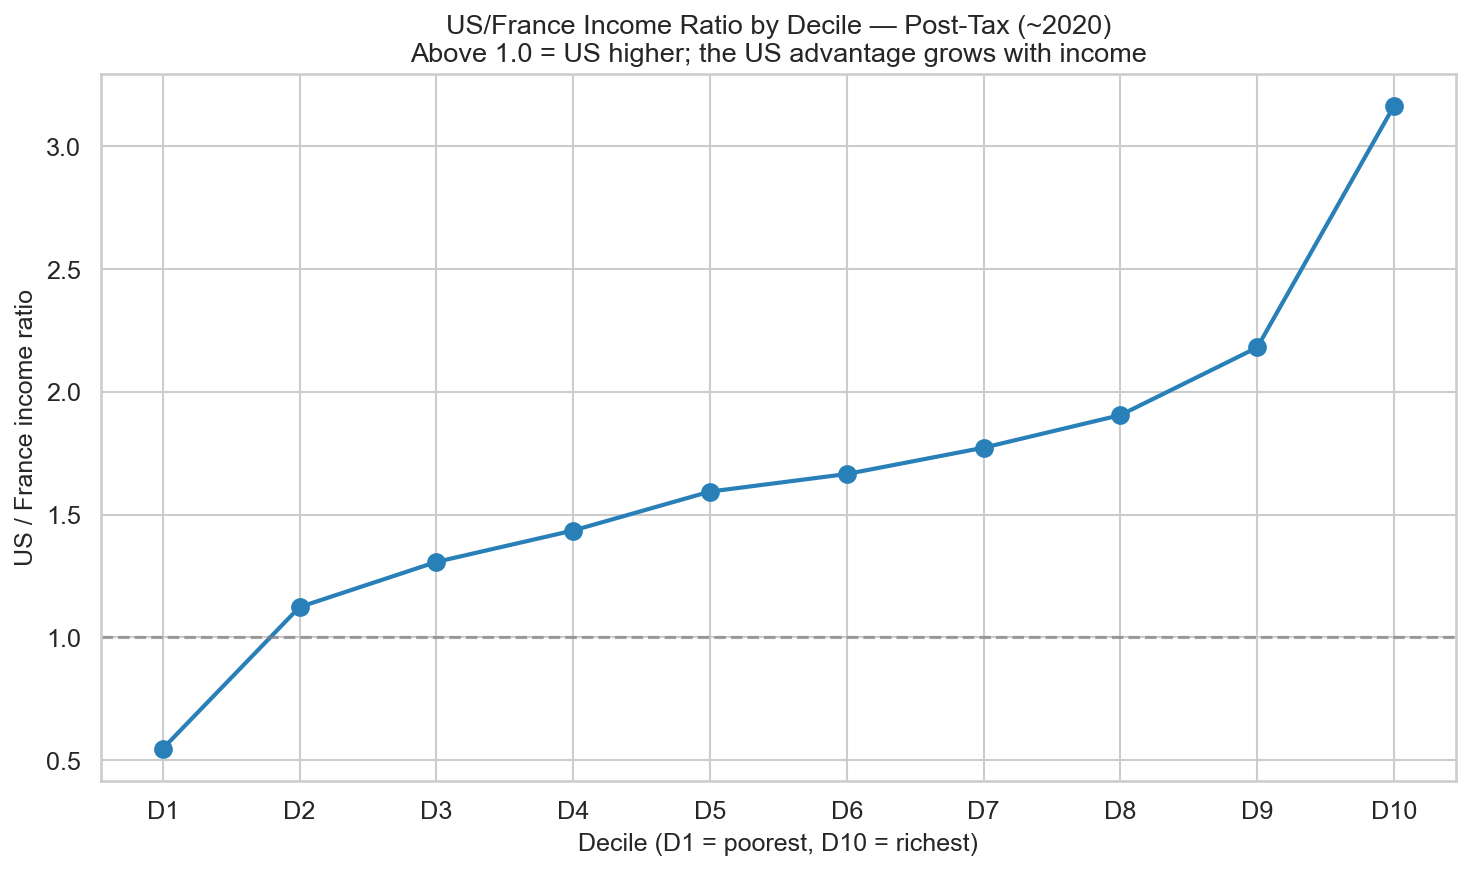

In [3]:
decile_pcts = [f'p{i*10}p{(i+1)*10}' for i in range(10)]

for concept, label in [('pretax', 'Pre-Tax'), ('posttax', 'Post-Tax')]:
    decile_income = wid.get_average_income(
        ['US', 'FR'], income_concept=concept, percentiles=decile_pcts,
        start_year=target_year - 2, end_year=target_year + 2,
    )
    if not decile_income.empty:
        decile_income['year_diff'] = abs(decile_income['year'] - target_year)
        latest = (decile_income.sort_values('year_diff')
                  .groupby(['country', 'percentile']).first().reset_index())
        us_data = latest[latest['country'] == 'US'].set_index('percentile')['value']
        fr_data = latest[latest['country'] == 'FR'].set_index('percentile')['value']
        common_pcts = sorted(set(us_data.index) & set(fr_data.index))
        if len(common_pcts) >= 5:
            ratios = [us_data[p] / fr_data[p] if fr_data[p] > 0 else np.nan for p in common_pcts]
            fig, ax = plt.subplots(figsize=(10, 6))
            decile_labels = [f'D{i+1}' for i in range(len(common_pcts))]
            ax.plot(decile_labels, ratios, 'o-', color='#2980b9', linewidth=2, markersize=8)
            ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)
            ax.set_xlabel('Decile (D1 = poorest, D10 = richest)')
            ax.set_ylabel('US / France income ratio')
            ax.set_title(f'US/France Income Ratio by Decile \u2014 {label} (~{target_year})\n'
                         'Above 1.0 = US higher; the US advantage grows with income', fontsize=13)
            plt.tight_layout()
            save_figure(fig, f'03_scissors_chart_{concept}')
            plt.show()
    else:
        print(f'Decile income data not available for {concept}.')

***
## 3. Growth Incidence Curves: Who Benefited from Growth?

A growth incidence curve shows cumulative income growth at each percentile.
In the US, growth since 1980 has been heavily concentrated at the top.
In France, growth has been more evenly distributed.

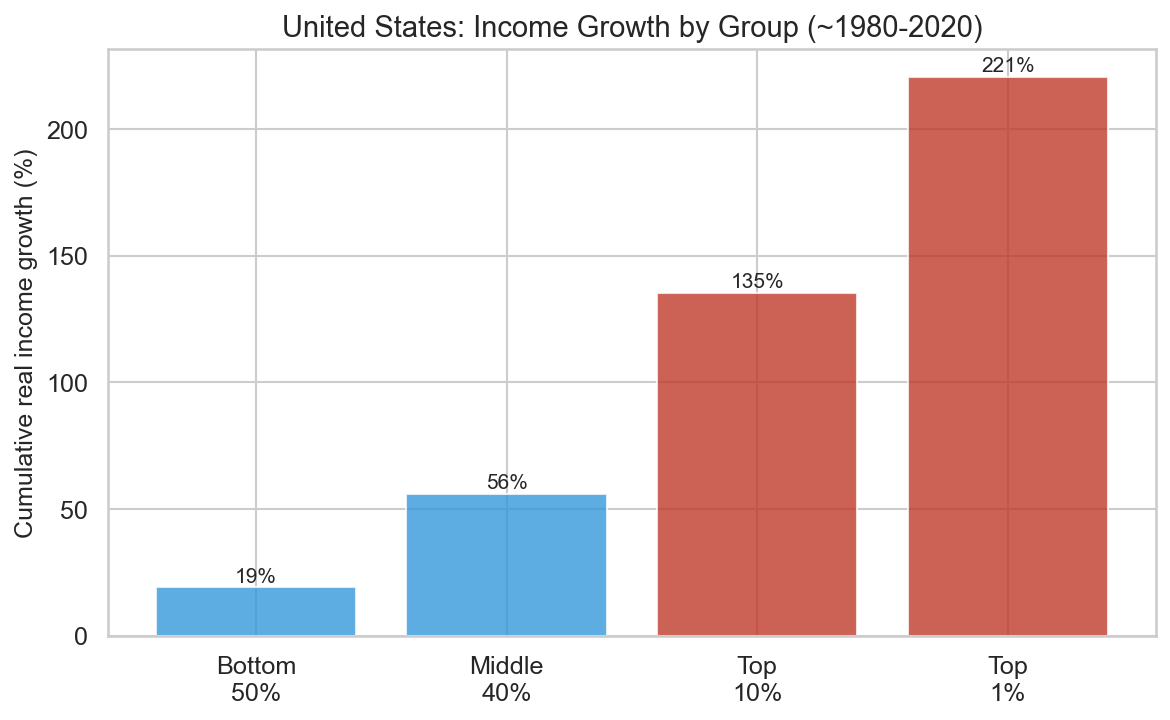

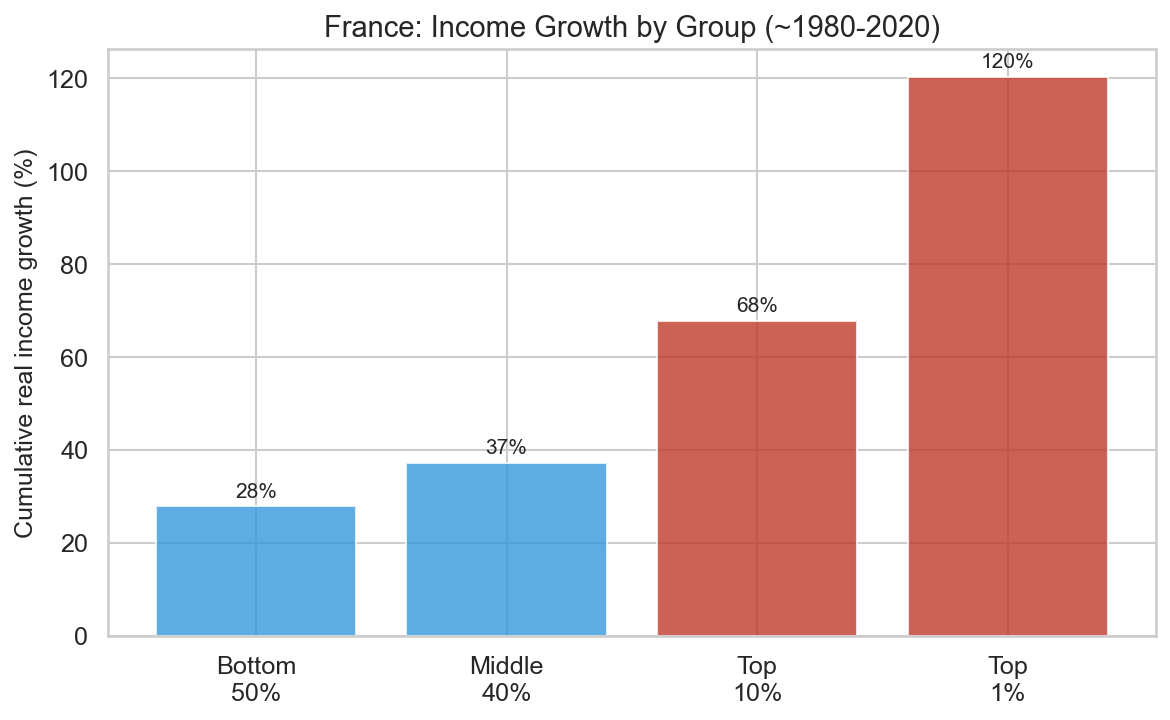

In [4]:
growth_pcts = ['p0p50', 'p50p90', 'p90p100', 'p99p100']

for cc in ['US', 'FR']:
    early = wid.get_average_income([cc], income_concept='pretax',
                                    percentiles=growth_pcts, start_year=1978, end_year=1982)
    late = wid.get_average_income([cc], income_concept='pretax',
                                   percentiles=growth_pcts, start_year=2018, end_year=2022)
    if not early.empty and not late.empty:
        early_avg = early.groupby('percentile')['value'].mean()
        late_avg = late.groupby('percentile')['value'].mean()
        common = sorted(set(early_avg.index) & set(late_avg.index))
        growth = [(late_avg[p] / early_avg[p] - 1) * 100 for p in common if early_avg[p] > 0]
        valid_pcts = [p for p in common if early_avg[p] > 0]
        if growth:
            pct_labels = {'p0p50': 'Bottom\n50%', 'p50p90': 'Middle\n40%',
                         'p90p100': 'Top\n10%', 'p99p100': 'Top\n1%'}
            labels = [pct_labels.get(p, p) for p in valid_pcts]
            fig, ax = plt.subplots(figsize=(8, 5))
            colors = ['#3498db' if g < np.mean(growth) else '#c0392b' for g in growth]
            ax.bar(labels, growth, color=colors, alpha=0.8)
            ax.set_ylabel('Cumulative real income growth (%)')
            ax.set_title(f'{country_name(cc)}: Income Growth by Group (~1980-2020)', fontsize=14)
            for i, g in enumerate(growth):
                ax.text(i, g + 2, f'{g:.0f}%', ha='center', fontsize=10)
            plt.tight_layout()
            save_figure(fig, f'03_growth_incidence_{cc}')
            plt.show()

***
## 4. Gini vs. Median Income: Is There a Trade-off?

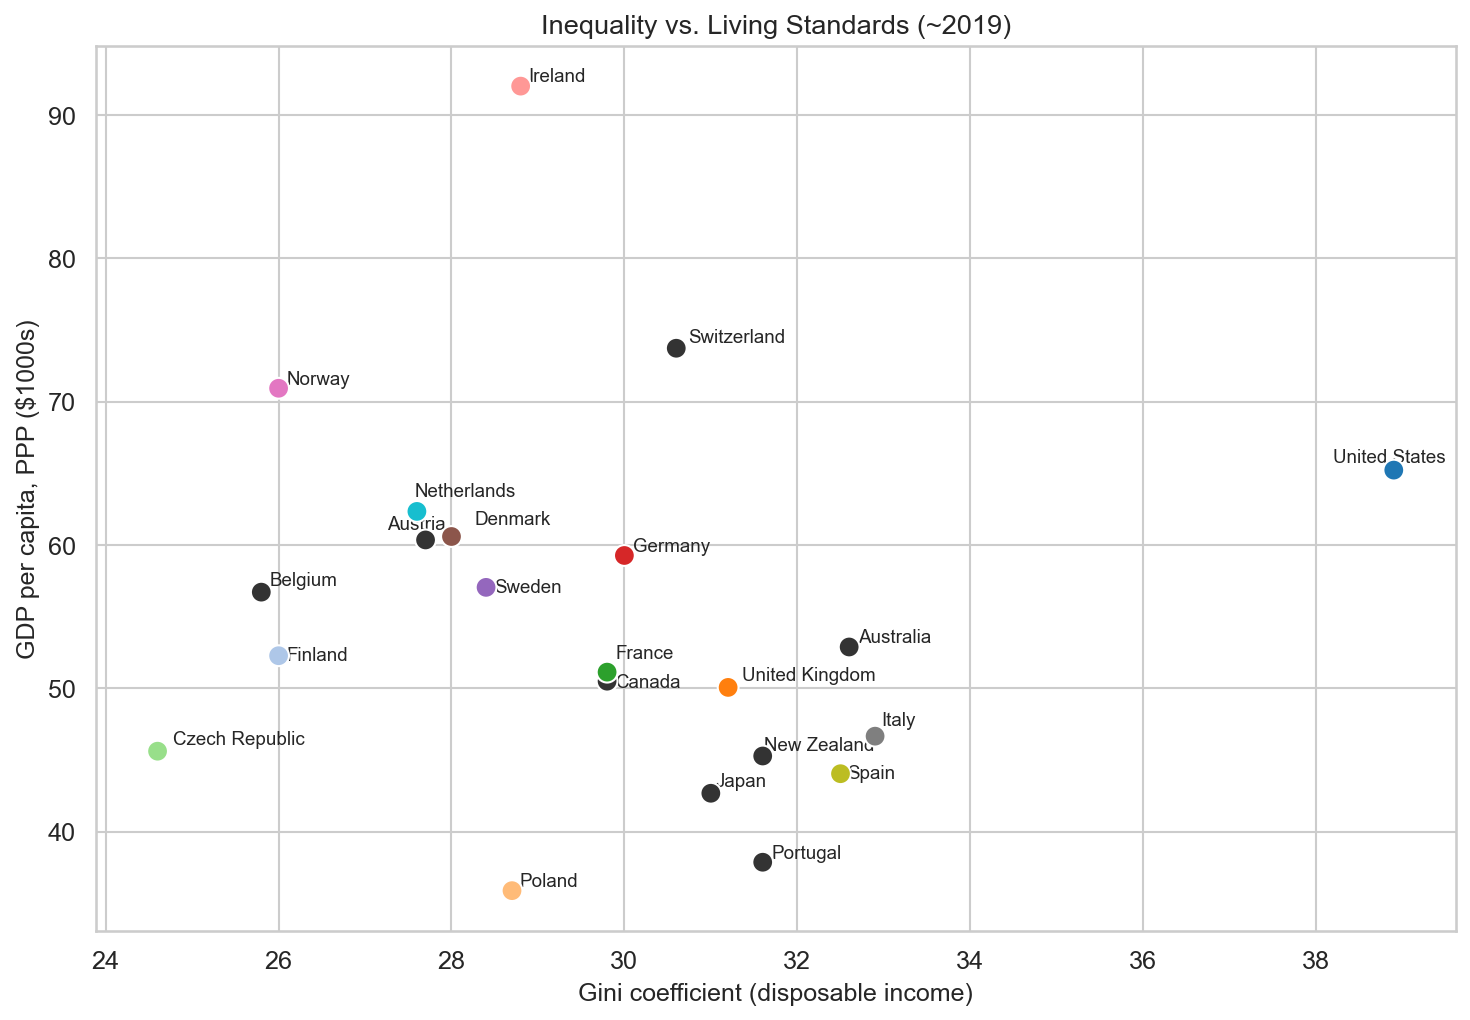

In [5]:
from data import health_social

spirit_data = health_social.get_spirit_level_data(year=2019)

if not spirit_data.empty and 'gini_disp' in spirit_data.columns and 'gdp_per_capita_ppp' in spirit_data.columns:
    plot_data = spirit_data.dropna(subset=['gini_disp', 'gdp_per_capita_ppp'])
    fig, ax = plt.subplots(figsize=(10, 7))
    colors = [country_color(c) if c in COUNTRY_NAMES else '#999' for c in plot_data['country_code']]
    ax.scatter(plot_data['gini_disp'], plot_data['gdp_per_capita_ppp'] / 1000,
               c=colors, s=100, zorder=5, edgecolors='white', linewidth=1)
    annotate_countries(ax, plot_data['gini_disp'].values,
                       (plot_data['gdp_per_capita_ppp'] / 1000).values,
                       plot_data['country_code'].values)
    ax.set_xlabel('Gini coefficient (disposable income)')
    ax.set_ylabel('GDP per capita, PPP ($1000s)')
    ax.set_title('Inequality vs. Living Standards (~2019)', fontsize=13)
    plt.tight_layout()
    save_figure(fig, '03_gini_vs_gdp')
    plt.show()
else:
    print('Health/social data not available for this chart.')

***
## Key Takeaways

1. **The US advantage is concentrated at the top.** At the 10th percentile, the gap narrows or reverses.
2. **Growth has been uneven.** US income growth since 1980 went disproportionately to the top.
3. **PPP comparisons have real limitations.** They don't capture the value of public services.
4. **There is no simple equality-prosperity trade-off.** Nordic countries achieve both.